# Machine Learning Engineer Nanodegree - Capstone Project
----
## *Differentiating between Icebergs and Ships from C-Band Satellite data*
### Sahil Singh

---

---

# 1. Introduction

This notebook is contains the development code used to explore the problem space, implement the solution and evaluate the results that were obtained. We will be working with the C-Band radar data obtained by the satellite Sentinal-1 to train a classification model so that it can effectively differentiate between Icebergs and Ships. The dataset is provided as part of an online competition on the data science platform **Kaggle**.

Our solution will be based on a Convolutional Neural Network architecture and will explore some image pre-processing techniques before implementing the deep learning model. Will also be using image augmentation techniques in the form of flipping, shearing and stretching. 

## Importing the data

In [1]:
# Importing the data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


train = pd.read_json('./dataset/train.json')
test = pd.read_json('./dataset/test.json')


## Exploratory Data Analysis 

### Angle of Incidence

In [2]:
train.info()
train.head()
print()
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1604 non-null object
is_iceberg    1604 non-null int64
dtypes: int64(1), object(4)
memory usage: 75.2+ KB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8424 entries, 0 to 8423
Data columns (total 4 columns):
band_1       8424 non-null object
band_2       8424 non-null object
id           8424 non-null object
inc_angle    8424 non-null float64
dtypes: float64(1), object(3)
memory usage: 329.1+ KB


,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",4023181e,32.615072
2,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",4371c8c3,43.918874


We see that all the fields except for the `is_iceberg` field have been read in as *object* types. We already know that the `inc_angle` field contains floating values with some NA values, so we convert this field to floating point numbers and preserve the NA values as such.

Total null values in `inc_angle` field: 0
Maximum angle of incidence: 45.9375
Minimum angle of incidence: 0.0
Mean angle of incidence: 36.01


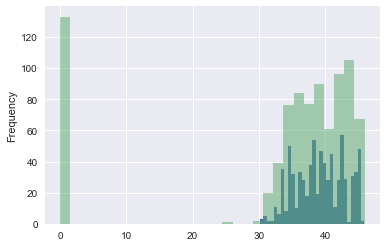

In [3]:
train['inc_angle'] = pd.to_numeric(train['inc_angle'],errors='coerce')
train.inc_angle = train.inc_angle.replace('na', 0)
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)

print("Total null values in `inc_angle` field: {}".format(train['inc_angle'].isnull().sum()))

train[train['is_iceberg'] == 1]['inc_angle'].plot.hist(label='Iceberg', bins=30)
train[train['is_iceberg'] == 0]['inc_angle'].plot.hist(label='Ship', bins=30, alpha=0.5)


print("Maximum angle of incidence: {}".format(train['inc_angle'].max()))
print("Minimum angle of incidence: {}".format(train['inc_angle'].min()))
print("Mean angle of incidence: {}".format(round(train['inc_angle'].mean(), 2)))

### Visualization of Images

In [4]:
print(len(train[train['is_iceberg'] == 1]))
print(len(train[train['is_iceberg'] == 0]))

753
851


In [5]:
icebergs = train[train['is_iceberg'] == 1].sample(n=6, random_state=42)
ships = train[train['is_iceberg'] == 0].sample(n=6, random_state=42)

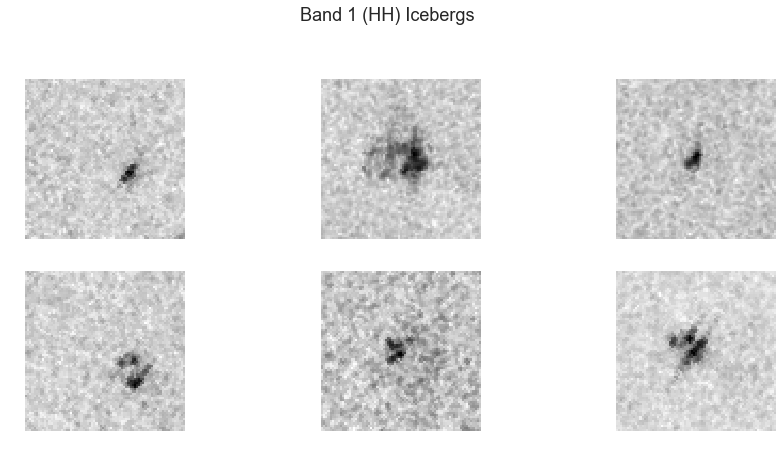

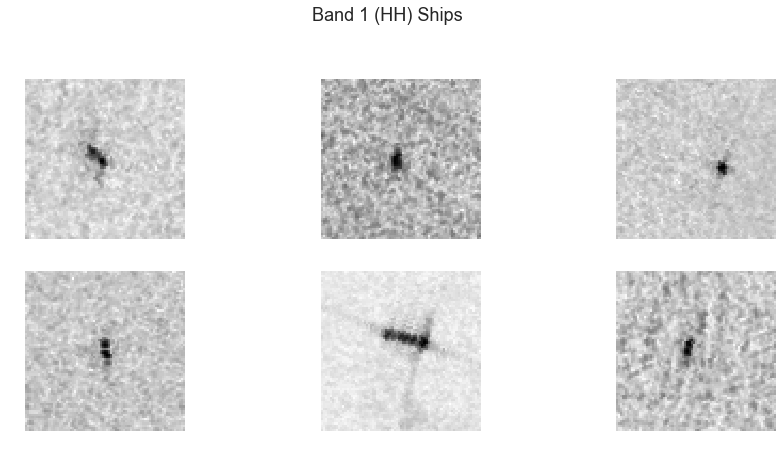

In [6]:
# Plot Band 1 data for Icebergs
fig = plt.figure(1,figsize=(15,10))
plt.suptitle('Band 1 (HH) Icebergs', fontsize=18)

for i in range(6):
    ax = fig.add_subplot(3,3,i+1)
    plt.axis('off')
    arr = np.reshape(np.array(icebergs.iloc[i,0]),(75,75))
    ax.imshow(arr,cmap='Greys')
    
plt.show()


# Plot Band 1 data for Ships
fig = plt.figure(2,figsize=(15,10))
plt.suptitle('Band 1 (HH) Ships', fontsize=18)

for i in range(6):
    ax = fig.add_subplot(3,3,i+1)
    plt.axis('off')
    arr = np.reshape(np.array(ships.iloc[i,0]),(75,75))
    ax.imshow(arr,cmap='Greys')
    
plt.show()


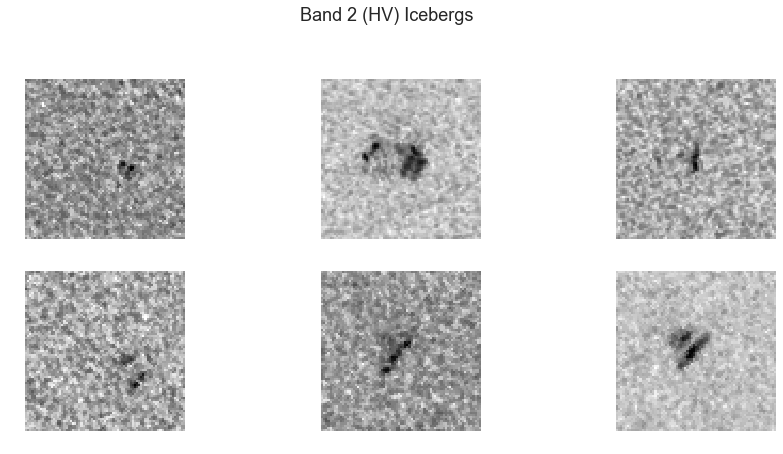

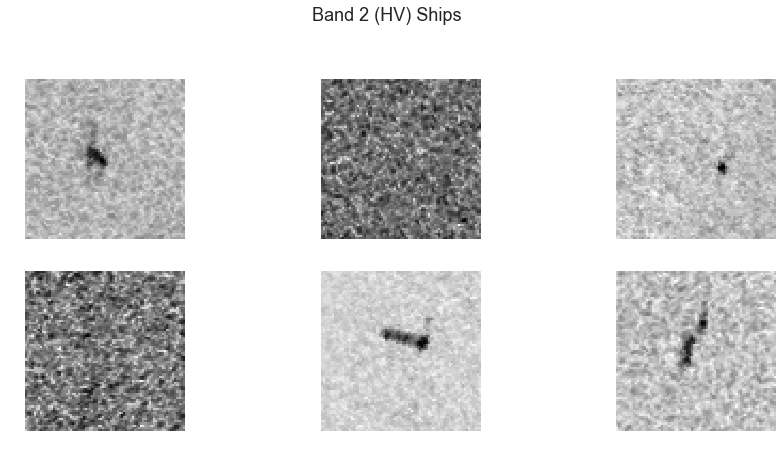

In [7]:
# Plot Band 2 data for Icebergs
fig = plt.figure(3,figsize=(15,10))
plt.suptitle('Band 2 (HV) Icebergs', fontsize=18)

for i in range(6):
    ax = fig.add_subplot(3,3,i+1)
    plt.axis('off')
    arr = np.reshape(np.array(icebergs.iloc[i,1]),(75,75))
    ax.imshow(arr,cmap='Greys')
    
plt.show()


# Plot Band 2 data for Ships
fig = plt.figure(4,figsize=(15,10))
plt.suptitle('Band 2 (HV) Ships', fontsize=18)

for i in range(6):
    ax = fig.add_subplot(3,3,i+1)
    plt.axis('off')
    arr = np.reshape(np.array(ships.iloc[i,1]),(75,75))
    ax.imshow(arr,cmap='Greys')
    
plt.show()


In images of the first band, we can clearly make out signal relative to the noise. Icebergs are largely seen as shapeless blobs while ships seem to have clear, even geometrical shapes.

In images of the second band, we see mostly observe the same, but here some images have no signal whatsoever and seem to be made up entirely of noise.

### Data Pre-Processing

The Sentinel-1 satellite data is recorded in 2 channels: HH and HV. We will add a composite third channel which will be the average of the HH and HV channels. 

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Transformations for the training data.
x_train_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
x_train_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
x_train_band3 = (x_train_band1 + x_train_band2)/2

X_train = np.concatenate([x_train_band1[:, :, :, np.newaxis],
                          x_train_band2[:, :, :, np.newaxis],
                          x_train_band3[:, :, :, np.newaxis]], axis=-1)

X_angle_train = np.array(train.inc_angle).reshape([-1, 1])
y_train = np.array(train["is_iceberg"])#.reshape([-1, 1])
 
# Final Test data (For submission)
x_test_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
x_test_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
x_test_band3 = (x_test_band1 + x_test_band2)/2

X_test_final = np.concatenate([x_test_band1[:, :, :, np.newaxis],
                               x_test_band2[:, :, :, np.newaxis],
                               x_test_band3[:, :, :, np.newaxis]], axis=-1)

X_angle_test_final = np.array(test.inc_angle).reshape([-1, 1])

# Transform the sample ships and icebergs data visualized previously for later use.
icebergs_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in icebergs["band_1"]])
icebergs_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in icebergs["band_2"]])
icebergs_band3 = (icebergs_band1 + icebergs_band2)/2
icebergs_tfd = np.concatenate([icebergs_band1[:, :, :, np.newaxis],
                               icebergs_band2[:, :, :, np.newaxis],
                               icebergs_band3[:, :, :, np.newaxis]], axis=-1)

ships_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in ships["band_1"]])
ships_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in ships["band_2"]])
ships_band3 = (ships_band1 + ships_band2)/2
ships_tfd = np.concatenate([ships_band1[:, :, :, np.newaxis],
                            ships_band2[:, :, :, np.newaxis],
                            ships_band3[:, :, :, np.newaxis]], axis=-1)

# Shuffle the entire dataset once
X_train, X_angle_train, y_train = shuffle(
    X_train, X_angle_train, y_train, random_state=42)

# Split training data into training, cross-validation and testing set.
X_train, X_test, X_angle_train, X_angle_test, y_train, y_test = train_test_split(
    X_train, X_angle_train, y_train, random_state=42, train_size=0.80)

X_train, X_valid, X_angle_train, X_angle_valid, y_train, y_valid = train_test_split(
    X_train, X_angle_train, y_train, random_state=42, train_size=0.80)

In [10]:
print("Training data shape: {}".format(X_train.shape))
print("Training incidence angle data shape: {}".format(X_angle_train.shape))
print("Training labels shape: {}".format(y_train.shape))
print()
print("Validation data shape: {}".format(X_valid.shape))
print("Validation angle data shape: {}".format(X_angle_valid.shape))
print("Validation labels shape: {}".format(y_valid.shape))
print()
print("Test data shape: {}".format(X_test.shape))
print("Test angle data shape: {}".format(X_angle_test.shape))
print("Test labels shape: {}".format(y_test.shape))
print()
print("Testing data shape: {}".format(X_test_final.shape))
print("Testing angle data shape: {}".format(X_angle_test_final.shape))

Training data shape: (1026, 75, 75, 3)
Training incidence angle data shape: (1026, 1)
Training labels shape: (1026,)

Validation data shape: (257, 75, 75, 3)
Validation angle data shape: (257, 1)
Validation labels shape: (257,)

Test data shape: (321, 75, 75, 3)
Test angle data shape: (321, 1)
Test labels shape: (321,)

Testing data shape: (8424, 75, 75, 3)
Testing angle data shape: (8424, 1)


In [11]:
import tensorflow as tf

tf.reset_default_graph()

def build_model(x, x_angle, keep_prob, training=True):
    """
        The model definition. 
        Args: 
            x: Placeholder - For the data input to be passed to the convolutional layers. 
            keep_prob : Placeholder - The dropout probability value with which to keep the neurons active.
            training: Placeholder - Boolean that specifies whether the network is training or not.

        Returns: Logits specifying the logit scores to be passed into a softmax classifier.
    """
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 75x75x3. Output = 73x73x16.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 16), mean = mu, stddev = sigma), name = 'layer_1_weights')
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID', name = 'conv_layer_1')
    batch_norm1 = tf.layers.batch_normalization(conv1, training=training, name = 'batch_norm_layer_1')
    act1 = tf.nn.relu(batch_norm1, name = 'activation_1')
    # Maxpool. Input = 73x73x16. Output = 72x72x16
    maxpool1 = tf.nn.max_pool(act1, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='VALID', name = 'maxpool_layer_1')
    #dropout1 = tf.nn.dropout(maxpool1, keep_prob, name = 'dropout_1')
    
    # Layer 2: Convolutional. Intput = 72x72x16. Output = 70x70x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 16, 32), mean = mu, stddev = sigma), name = 'layer_2_weights')
    conv2   = tf.nn.conv2d(maxpool1, conv2_W, strides=[1, 1, 1, 1], padding='VALID', name = 'conv_layer_2')
    batch_norm2 = tf.layers.batch_normalization(conv2, training=training, name = 'batch_norm_layer_2')
    act2 = tf.nn.relu(batch_norm2, name = 'activation_2')
    # Maxpool. Input = 70x70x32. Output = 35x35x32
    maxpool2 = tf.nn.max_pool(act2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name = 'maxpool_layer_2')
    #dropout2 = tf.nn.dropout(maxpool2, keep_prob, name = 'dropout_2')
    
    # Layer 3: Convolutional. Input = 35x35x32 Output = 16x16x64
    conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean = mu, stddev = sigma), name = 'layer_3_weights')
    conv3   = tf.nn.conv2d(maxpool2, conv3_W, strides=[1, 2, 2, 1], padding='VALID', name = 'conv_layer_3')
    batch_norm3 = tf.layers.batch_normalization(conv3, training=training, name = 'batch_norm_layer_3')
    act3 = tf.nn.relu(batch_norm3, name = 'activation_3')
    # Maxpool. Input = 16x16x64. Output = 15x15x64
    maxpool3 = tf.nn.max_pool(act3, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='VALID', name = 'maxpool_layer_3')
    #dropout3 = tf.nn.dropout(maxpool3, keep_prob, name = 'dropout_3')
    
    # Layer 4: Convolutional. Input = 15x15x64 Output = 13x13x128
    conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = mu, stddev = sigma), name = 'layer_4_weights')
    conv4   = tf.nn.conv2d(maxpool3, conv4_W, strides=[1, 1, 1, 1], padding='VALID', name = 'conv_layer_4')
    batch_norm4 = tf.layers.batch_normalization(conv4, training=training, name = 'batch_norm_layer_4')
    act4 = tf.nn.relu(batch_norm4, name = 'activation_4')
    # Maxpool. Input = 13x13x128. Output = 12x12x128
    maxpool4 = tf.nn.max_pool(act4, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='VALID', name = 'maxpool_layer_4')
    #dropout4 = tf.nn.dropout(maxpool4, keep_prob, name = 'dropout_4')
    
    # Reshape operation. Flattens out the previous convolutional layer.
    dropout4_shape = maxpool4.get_shape().as_list() # 12x12x128
    fc0 = tf.reshape(maxpool4, [-1, np.prod(dropout4_shape[1:])]) # 12x12x128 = 18,432
    
    # Concat with angle data
    concat_layer = tf.concat([fc0, x_angle], axis=1) # 18,433
    
    # Layer 5: Fully Connected. Input = 18,433. Output = 1024
    fc1_W = tf.Variable(
        tf.truncated_normal(shape=((np.prod(dropout4_shape[1:]) + 1), 1024), mean = mu, stddev = sigma), name = 'layer_5_weights')
    fc1   = tf.matmul(concat_layer, fc1_W, name = 'weighted_inputs_5') 
    batch_norm_fc1 = tf.layers.batch_normalization(fc1, training=training)
    act_fc1    = tf.nn.relu(batch_norm_fc1)
    dropout_fc1 = tf.nn.dropout(act_fc1, keep_prob)
    
    # Layer 6: Fully Connected. Input = 1024. Output = 1024.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(1024, 1024), mean = mu, stddev = sigma))
    fc2    = tf.matmul(dropout_fc1, fc2_W)
    batch_norm_fc2 = tf.layers.batch_normalization(fc2, training=training)
    act_fc2    = tf.nn.relu(batch_norm_fc2)
    dropout_fc2 = tf.nn.dropout(act_fc2, keep_prob)
    
    # Layer 7: Fully Connected. Input = 1024. Output = 128.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(1024, 128), mean = mu, stddev = sigma))
    fc3    = tf.matmul(act_fc2, fc3_W)
    batch_norm_fc3 = tf.layers.batch_normalization(fc3, training=training)
    act_fc3    = tf.nn.relu(batch_norm_fc3)
    dropout_fc3 = tf.nn.dropout(act_fc3, keep_prob)

    # Layer 8: Output Layer. Input = 128. Output = 2.
    fc4_W  = tf.Variable(tf.truncated_normal(shape=(128, 2), mean = mu, stddev = sigma))
    fc4    = tf.matmul(dropout_fc3, fc4_W)
    
    logits = tf.identity(fc4, name = 'logits')
    return logits
    
    

In [12]:
def get_batches(dataset, size):
    """
    Generator function for creating and iterating over batches of the input dataset.

    Args
    dataset: (ndarray, ndarray, ndarray)
        Tuple of numpy arrays representing the training set and their respective labels.
    batch_size: int 
        Size of the generated batches.

    Returns: (ndarray, ndarray)
        Tuple of the mini-batch generated by the function.
    """
    
    if len(dataset) == 3:
        for ix in range(0, len(dataset[2]), size):
            yield dataset[0][ix: ix+size], dataset[1][ix: ix+size], dataset[2][ix: ix+size]
    else:
        for ix in range(0, len(dataset[1]), size):
            yield dataset[0][ix: ix+size], dataset[1][ix: ix+size]

        
        
# Define placeholders for the input samples and labels 
inputs = tf.placeholder(tf.float32, [None, 75, 75, 3], name="inputs")
input_angles = tf.placeholder(tf.float32, [None, 1], name='input_angles')
labels = tf.placeholder(tf.int32, [None], name='labels')

is_training = tf.placeholder(tf.bool, name='is_training')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
learning_rate = tf.placeholder(tf.float32, name='learning_rate')

# Apply random transformation to image tensors
flip1 = tf.less(tf.random_uniform((), 0., 1.), 0.5)
flip2 = tf.less(tf.random_uniform((), 0., 1.), 0.5)
#flip3 = tf.less(tf.random_uniform((), 0., 1.), 0.5)

transform1 = tf.cond(flip1, lambda: tf.map_fn(lambda img: tf.image.flip_up_down(img), inputs), lambda: inputs)
transform2 = tf.cond(flip2, lambda: tf.map_fn(lambda img: tf.image.flip_left_right(img), transform1), lambda: transform1)
#transform3 = tf.cond(flip3, lambda: tf.map_fn(lambda img: tf.image.rot90(img), transform2), lambda: transform2)

conditional_input = tf.cond(is_training, lambda: transform2, lambda: inputs, name="conditional_input")

# Get Logits
logits = build_model(conditional_input, input_angles, keep_prob, is_training)

# Define Loss and training operation
model_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits = logits, labels = tf.one_hot(labels, 2)))

with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    train_opt = tf.train.AdamOptimizer(learning_rate).minimize(model_loss)

#predictions = tf.greater(tf.nn.sigmoid(logits), 0.5)
#correct_predictions = tf.equal(tf.cast(predictions, tf.int32), labels)
#accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

correct_predictions = tf.equal(tf.argmax(logits, 1), tf.argmax(tf.one_hot(labels, 2), 1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

The function below will be used to plot the model accuracy metrics for training and cross-validation sets.

In [120]:
def plot_metrics(training_acc, validation_acc, savefile=False):
    """
    Function to plot and save the accuracy and cross validation metrics returned 
    by the model training function. 
    
    Args
    accuracy_acc: Array
        The training accuracies, one per epoch of training.
    validation_acc: Array
        The validation accuracies, one per epoch of training.
        
    Returns
    None
    """
    fig = plt.figure(figsize=(6,3))
    plt.plot(training_acc, label="Training")
    plt.plot(validation_acc, label="Validation")
    #plt.title("Accuracy over 100 epochs")
    plt.tight_layout()
    plt.legend()
    
    if savefile:
        plt.savefig(savefile, dpi=100)
    
    plt.show()

In [33]:
def train_model(epochs, batch_size, lr, dropout):
    
    training_accuracies = []
    validation_accuracies = []

    # Train and test the network.
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for epoch in range(epochs):
            print("Epoch {:>3d}".format(epoch))
            batch_generator = get_batches((X_train, X_angle_train, y_train), batch_size)
            
            """
            # Overfit on a small slice of training data to check whether model works.
            batch_generator = get_batches((
                X_train[:100,:,:,:], 
                X_angle_train[:100], 
                y_train[:100]), batch_size)
            """
            
            for batch_i in range((len(y_train) // batch_size) + 1):
                batch_xs, batch_xangles, batch_ys = next(batch_generator)
                
                sess.run(train_opt, {
                    inputs : batch_xs,
                    input_angles: batch_xangles,
                    labels : batch_ys,
                    learning_rate : lr,
                    keep_prob : dropout,
                    is_training : True})
                
                if batch_i % 50 == 0:
                    loss, acc = sess.run([model_loss, accuracy], 
                            {inputs: X_valid,
                             input_angles: X_angle_valid,
                             labels: y_valid,
                             keep_prob : 1.0,
                             is_training: False})
                    print('Batch: {:>2}: Validation loss: {:>3.5f}, Validation accuracy: {:>3.5f}'.format(batch_i, loss, acc))
                    training_accuracies.append(acc)
                elif batch_i % 3 == 0:
                    loss, acc = sess.run([model_loss, accuracy], 
                            {inputs: batch_xs, 
                             input_angles: batch_xangles,
                             labels: batch_ys, 
                             keep_prob : 1.0,
                             is_training: False})
                    print('Batch: {:>2}: Training loss: {:>3.5f}, Training accuracy: {:>3.5f}'.format(batch_i, loss, acc))
                    validation_accuracies.append(acc)
                
        acc = sess.run(accuracy, {inputs: X_valid,
                                  input_angles: X_angle_valid,
                                  labels: y_valid, 
                                  keep_prob : 1.0,
                                  is_training: False})
        print('Final validation accuracy: {:>3.5f}'.format(acc))

        
        """
        ### Batchify testing data (entire dataset is leading to OOM errors.)
        test_accuracy = 0
        batch_num = len(X_test)//512
        
        for i in range(batch_num):
            test_batch = get_batches((X_test, y_test), 512)
            X_test_batch, y_test_batch = next(test_batch)
            
            acc = sess.run(accuracy, {inputs: X_test_batch,
                                      labels: y_test_batch,
                                      keep_prob : 1.0,
                                      is_training: False})
            test_accuracy += acc
            
        print('Final test accuracy: {:>3.5f}'.format(test_accuracy/batch_num))
        """
    
        # Score the first 100 test images individually, just to make sure batch normalization really worked
        correct = 0
        for i in range(100):
            correct += sess.run(accuracy,feed_dict={inputs: [X_test[i]],
                                                    input_angles: [X_angle_test[i]],
                                                    labels: [y_test[i]],
                                                    keep_prob : 1.0,
                                                    is_training: False})

        print("Accuracy on 100 samples:", correct/100)

        test_acc = sess.run(accuracy, {
                          inputs: X_test,
                          input_angles: X_angle_test,
                          labels: y_test,
                          keep_prob : 1.0,
                          is_training: False})
        
        print('Final test accuracy: {:>3.5f}'.format(test_acc))

        
        saver = tf.train.Saver()
        saver.save(sess, 'checkpoints/model.ckpt')
        
    return training_accuracies, validation_accuracies


train_acc, validation_acc = train_model(epochs=100, batch_size=256, lr=0.001, dropout=0.5)

Epoch   0
Batch:  0: Validation loss: 1257.34290, Validation accuracy: 0.54864
Batch:  3: Training loss: 1670.50415, Training accuracy: 0.51172
Epoch   1
Batch:  0: Validation loss: 1408.13013, Validation accuracy: 0.54864
Batch:  3: Training loss: 998.48547, Training accuracy: 0.51172
Epoch   2
Batch:  0: Validation loss: 783.02710, Validation accuracy: 0.54864
Batch:  3: Training loss: 650.89948, Training accuracy: 0.51172
Epoch   3
Batch:  0: Validation loss: 543.21429, Validation accuracy: 0.54864
Batch:  3: Training loss: 439.88058, Training accuracy: 0.51172
Epoch   4
Batch:  0: Validation loss: 348.11658, Validation accuracy: 0.54864
Batch:  3: Training loss: 290.62036, Training accuracy: 0.51172
Epoch   5
Batch:  0: Validation loss: 235.78748, Validation accuracy: 0.54864
Batch:  3: Training loss: 218.52980, Training accuracy: 0.51172
Epoch   6
Batch:  0: Validation loss: 180.19217, Validation accuracy: 0.54864
Batch:  3: Training loss: 157.27293, Training accuracy: 0.51172
Epo

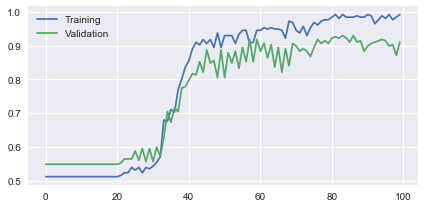

In [121]:
# Plot Training and validation accuracies

plot_metrics(train_acc, validation_acc, "accuracy_plot.png")

### Evaluating the model for robustness

To check whether our model's performance is reliable and robust against fluctuations in the data, we will evaluate it against the previously sampled and visualized images from the training set and the held out testing set, adding a certain amount of noise to these images. 


In [122]:
def show_image(image, title, savefile=False):
    fig = plt.figure()
    plt.suptitle(title)
    plt.subplot(1,2,1)
    plt.title("HH band")
    plt.tight_layout()
    plt.grid('off')
    plt.axis('off')
    plt.imshow(image[:,:,0], cmap='Greys')
    plt.subplot(1,2,2)
    plt.title("HV Band")
    plt.tight_layout()
    plt.grid('off')
    plt.axis('off')
    plt.imshow(image[:,:,1], cmap='Greys')
    if savefile:
        plt.savefig(savefig)
    
def show_barplot(orig_top_k, noisy_top_k, ix, title, savefile=False):
    fig = plt.figure()
    plt.suptitle('Softmax probabilities for {} {}'.format(title, ix+1))
    plt.subplot(1, 2, 1)
    plt.title('Original')
    plt.subplots_adjust(hspace=0.7)
    plt.xlabel('Class')
    plt.ylabel('Softmax Prob.')
    sns.barplot(orig_top_k.indices[ix], orig_top_k.values[ix], palette=sns.dark_palette("Purple"))
    #plt.savefig('examples/softmax_scores.png', dpi=100, bbox_inches='tight')
    plt.subplot(1, 2, 2)
    plt.title('Noisy')
    plt.subplots_adjust(hspace=0.7)
    plt.xlabel('Class')
    plt.ylabel('Softmax Prob.')
    sns.barplot(noisy_top_k.indices[ix], noisy_top_k.values[ix], palette=sns.dark_palette("Purple"))
    if savefile:
        plt.savefig(savefig)

# Generate random noise to add to images
noise = np.random.normal(loc=0, scale=2, size=[6,75,75,3])

# Add noise to images
noisy_ship_images = ships_tfd + noise
noisy_iceberg_images = icebergs_tfd + noise



INFO:tensorflow:Restoring parameters from ./checkpoints/model.ckpt


/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


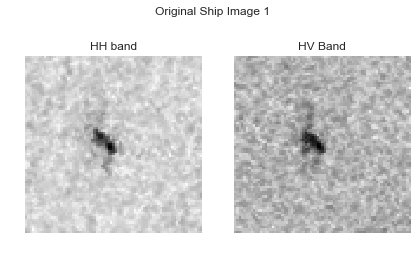

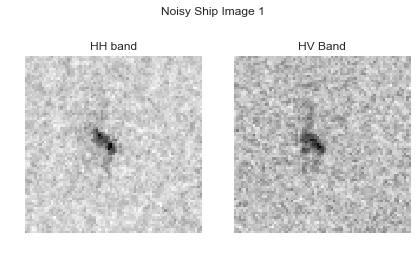

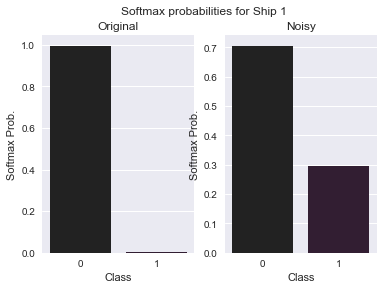

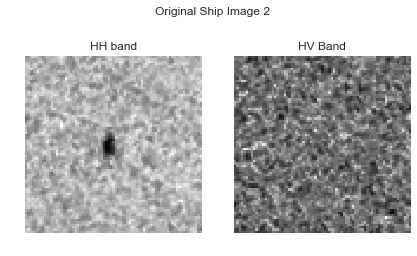

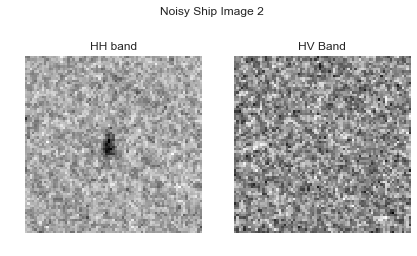

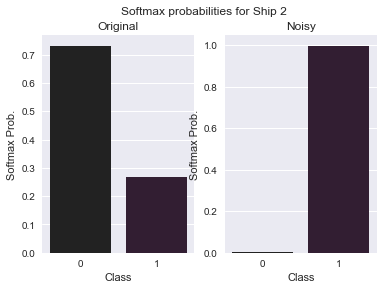

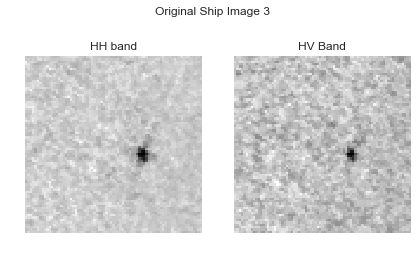

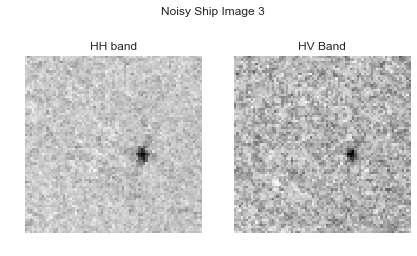

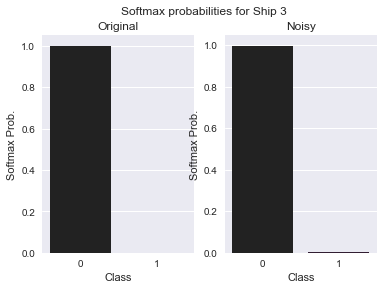

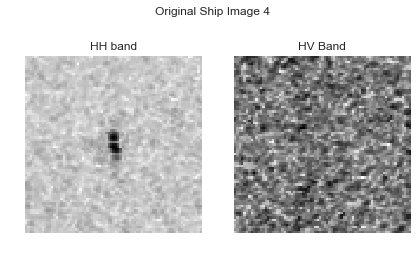

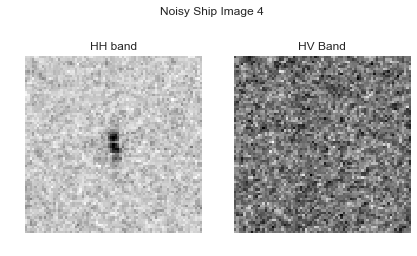

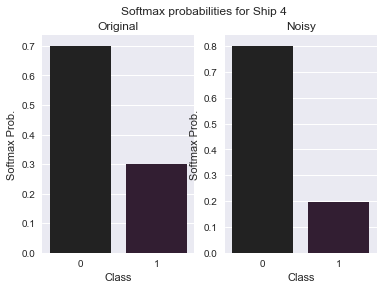

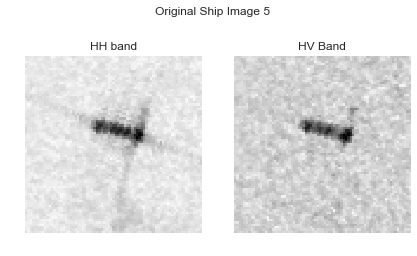

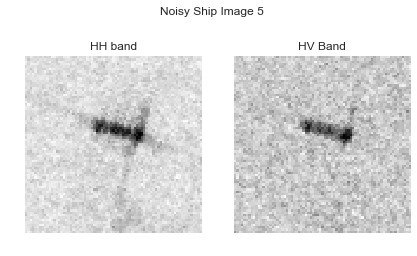

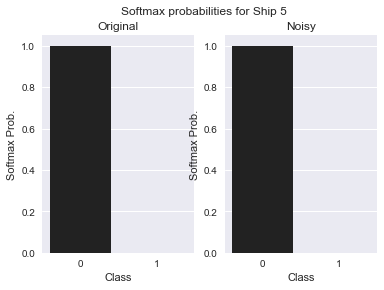

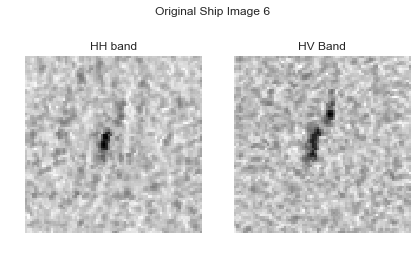

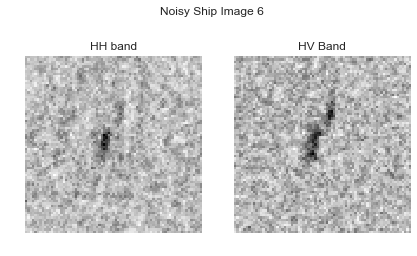

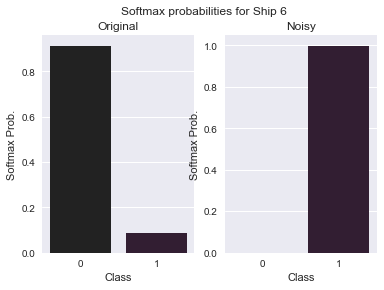

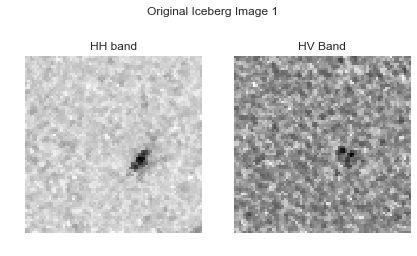

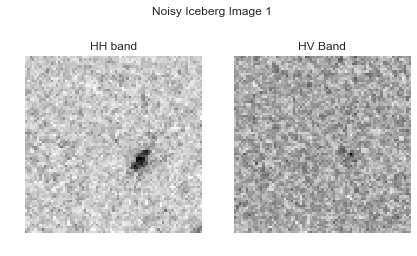

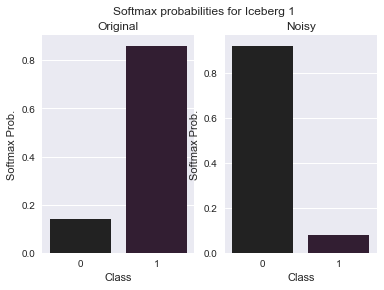

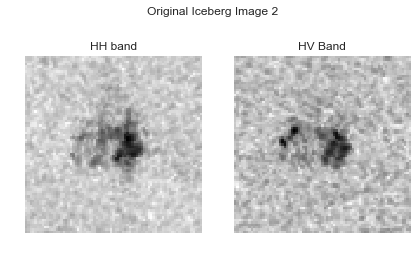

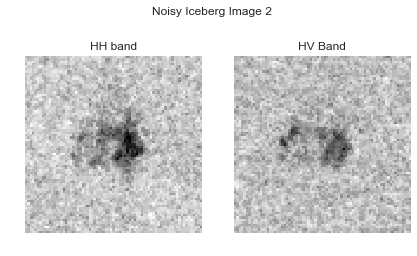

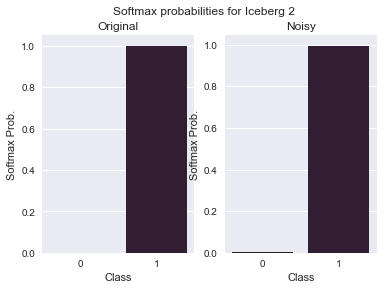

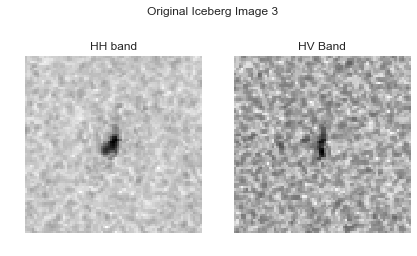

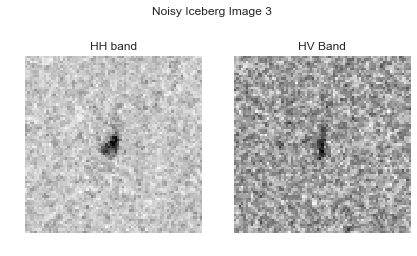

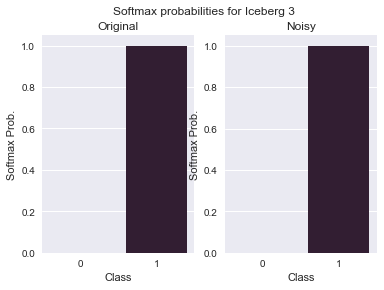

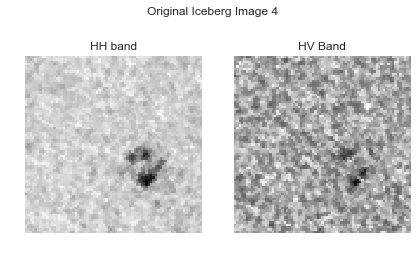

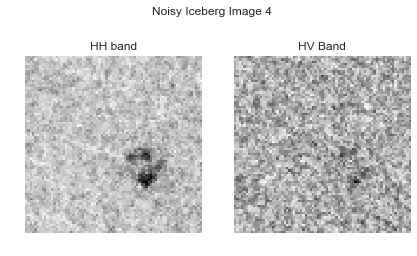

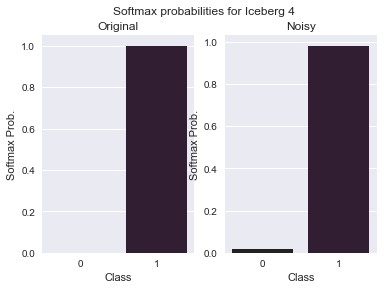

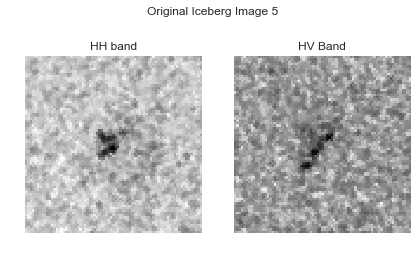

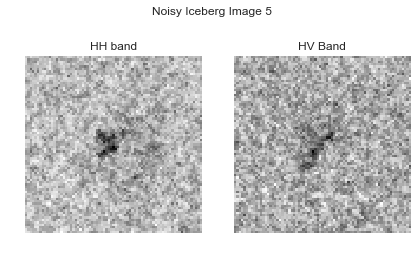

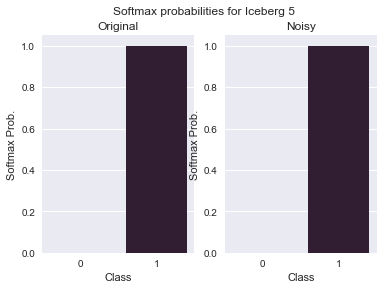

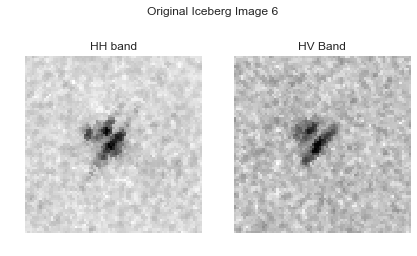

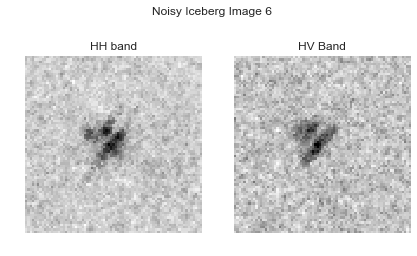

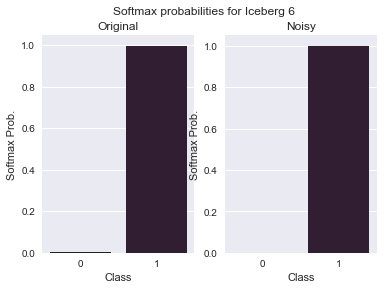

In [123]:

with tf.Session() as sess:
    
    saver.restore(sess, "./checkpoints/model.ckpt")
    
    top_2_softmax_original_ships = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=2), feed_dict = {
        inputs : ships_tfd,
        input_angles: ships['inc_angle'].values.reshape([-1,1]),
        keep_prob : 1.0,
        is_training : False
    })
    
    top_2_softmax_noisy_ships = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=2), feed_dict = {
        inputs : noisy_ship_images,
        input_angles: ships['inc_angle'].values.reshape([-1,1]),
        keep_prob : 1.0,
        is_training : False
    })
    
    top_2_softmax_original_icebergs = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=2), feed_dict = {
        inputs : icebergs_tfd,
        input_angles: icebergs['inc_angle'].values.reshape([-1,1]),
        keep_prob : 1.0,
        is_training : False
    })
    
    top_2_softmax_noisy_icebergs = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=2), feed_dict = {
        inputs : noisy_iceberg_images,
        input_angles: icebergs['inc_angle'].values.reshape([-1,1]),
        keep_prob : 1.0,
        is_training : False
    })


# Show original and noisy ship images
for ix in range(len(ships_tfd)):
    show_image(ships_tfd[ix], "Original Ship Image {}".format(ix+1))
    show_image(noisy_ship_images[ix], "Noisy Ship Image {}".format(ix+1))
    show_barplot(top_2_softmax_original_ships, top_2_softmax_noisy_ships, ix, "Ship")
    
# Show original and noisy iceberg images
for ix in range(len(icebergs_tfd)):
    show_image(icebergs_tfd[ix], "Original Iceberg Image {}".format(ix+1))
    show_image(noisy_iceberg_images[ix], "Noisy Iceberg Image {}".format(ix+1))
    show_barplot(top_2_softmax_original_icebergs, top_2_softmax_noisy_icebergs, ix, "Iceberg")

In [125]:
def show_image(image, title, savefile=False):
    fig = plt.figure()
    #plt.suptitle(title)
    plt.subplot(1,2,1)
    plt.title("HH band")
    plt.tight_layout()
    plt.grid('off')
    plt.axis('off')
    plt.imshow(image[:,:,0], cmap='Greys')
    plt.subplot(1,2,2)
    plt.title("HV Band")
    plt.tight_layout()
    plt.grid('off')
    plt.axis('off')
    plt.imshow(image[:,:,1], cmap='Greys')
    if savefile:
        plt.savefig(savefile)
    
def show_barplot(orig_top_k, noisy_top_k, ix, title, savefile=False):
    fig = plt.figure()
    #plt.suptitle('Softmax probabilities for {} {}'.format(title, ix+1))
    plt.subplot(1, 2, 1)
    plt.title('Original')
    plt.subplots_adjust(hspace=1)
    plt.xlabel('Class')
    plt.ylabel('Softmax Prob.')
    sns.barplot(orig_top_k.indices[ix], orig_top_k.values[ix], palette=sns.dark_palette("Purple"))
    #plt.savefig('examples/softmax_scores.png', dpi=100, bbox_inches='tight')
    plt.subplot(1, 2, 2)
    plt.title('Noisy')
    plt.subplots_adjust(hspace=1)
    plt.xlabel('Class')
    plt.ylabel('Softmax Prob.')
    sns.barplot(noisy_top_k.indices[ix], noisy_top_k.values[ix], palette=sns.dark_palette("Purple"))
    if savefile:
        plt.savefig(savefile)
"""      
# Show original and noisy ship images
for ix in range(len(ships_tfd)):
    show_image(ships_tfd[ix], "Original Ship Image {}".format(ix+1))
    show_image(noisy_ship_images[ix], "Noisy Ship Image {}".format(ix+1))
    show_barplot(top_2_softmax_original_ships, top_2_softmax_noisy_ships, ix, "Ship")
    
# Show original and noisy iceberg images
for ix in range(len(icebergs_tfd)):
    show_image(icebergs_tfd[ix], "Original Iceberg Image {}".format(ix+1))
    show_image(noisy_iceberg_images[ix], "Noisy Iceberg Image {}".format(ix+1))
    show_barplot(top_2_softmax_original_icebergs, top_2_softmax_noisy_icebergs, ix, "Iceberg")
"""

'      \n# Show original and noisy ship images\nfor ix in range(len(ships_tfd)):\n    show_image(ships_tfd[ix], "Original Ship Image {}".format(ix+1))\n    show_image(noisy_ship_images[ix], "Noisy Ship Image {}".format(ix+1))\n    show_barplot(top_2_softmax_original_ships, top_2_softmax_noisy_ships, ix, "Ship")\n    \n# Show original and noisy iceberg images\nfor ix in range(len(icebergs_tfd)):\n    show_image(icebergs_tfd[ix], "Original Iceberg Image {}".format(ix+1))\n    show_image(noisy_iceberg_images[ix], "Noisy Iceberg Image {}".format(ix+1))\n    show_barplot(top_2_softmax_original_icebergs, top_2_softmax_noisy_icebergs, ix, "Iceberg")\n'

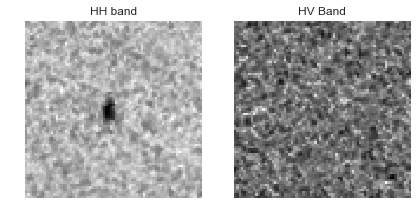

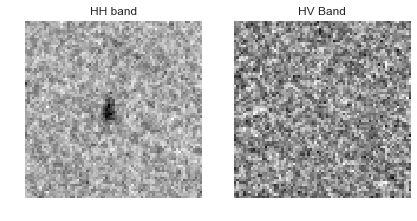

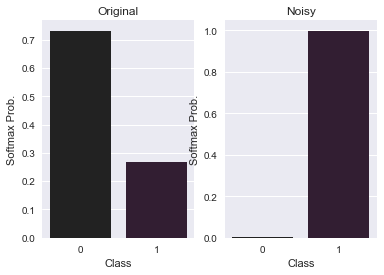

In [128]:
show_image(ships_tfd[1], None, "original_ship.png")#"Original Ship Image {}".format(3+1))
show_image(noisy_ship_images[1], None, "noisy_ship.png")# "Noisy Ship Image {}".format(3+1))
show_barplot(top_2_softmax_original_ships, top_2_softmax_noisy_ships, 1, "Ship", "softmax_ship.png")
   

In [129]:
# Evaluate the model on the original and noisy sampled ship images

saver = tf.train.Saver()

with tf.Session() as sess:
    
    saver.restore(sess, "./checkpoints/model.ckpt")

    predictions_ship_original = sess.run(tf.argmax(logits, 1), feed_dict = {
          inputs: ships_tfd,
          input_angles: ships['inc_angle'].values.reshape([-1,1]),
          keep_prob : 1.0,
          is_training: False})
    
    predictions_ship_noisy = sess.run(tf.argmax(logits, 1), feed_dict = {
          inputs: noisy_ship_images,
          input_angles: ships['inc_angle'].values.reshape([-1,1]),
          keep_prob : 1.0,
          is_training: False})
    
    


print(predictions_ship_original)
print(predictions_ship_noisy)



INFO:tensorflow:Restoring parameters from ./checkpoints/model.ckpt
[0 0 0 0 0 0]
[0 1 0 0 0 1]


In [130]:
# Evaluate the model on the original and noisy sampled iceberg images

saver = tf.train.Saver()

with tf.Session() as sess:
    
    saver.restore(sess, "./checkpoints/model.ckpt")

    predictions_iceberg_original = sess.run(tf.argmax(logits, 1), feed_dict = {
          inputs: icebergs_tfd,
          input_angles: icebergs['inc_angle'].values.reshape([-1,1]),
          keep_prob : 1.0,
          is_training: False})
    
    predictions_iceberg_noisy = sess.run(tf.argmax(logits, 1), feed_dict = {
          inputs: noisy_iceberg_images,
          input_angles: icebergs['inc_angle'].values.reshape([-1,1]),
          keep_prob : 1.0,
          is_training: False})
    
    


print(predictions_iceberg_original)
print(predictions_iceberg_noisy)



INFO:tensorflow:Restoring parameters from ./checkpoints/model.ckpt
[1 1 1 1 1 1]
[0 1 1 1 1 1]


### Evaluating the model on the held out test dataset with added noise.

In [131]:
test_noise = np.random.normal(loc=0, scale=2, size=[321,75,75,3])
noisy_test_images = test_noise + X_test

with tf.Session() as sess:
    
    saver.restore(sess, "./checkpoints/model.ckpt")

    noisy_test_acc = sess.run(accuracy, {
          inputs: noisy_test_images,
          input_angles: X_angle_test,
          labels: y_test,
          keep_prob : 1.0,
          is_training: False})
        
    print('Final test accuracy: {:>3.5f}'.format(noisy_test_acc))

INFO:tensorflow:Restoring parameters from ./checkpoints/model.ckpt
Final test accuracy: 0.79439


### Testing on the Final Testing Set (Submissions)

In [34]:
saver = tf.train.Saver()

with tf.Session() as sess:
    
    saver.restore(sess, "./checkpoints/model.ckpt")
    """
    predictions = sess.run(tf.argmax(logits, 1), feed_dict = {
          inputs: X_test_final,
          input_angles: X_angle_test_final,
          keep_prob : 1.0,
          is_training: False})
    
    
    """
    batch_num = len(X_test_final)//24
    all_preds = np.array([])

    for i in range(batch_num):
        test_batch = get_batches((X_test_final, X_angle_test_final), 24)
        X_test_final_batch, X_angle_test_final_batch = next(test_batch)

        preds = sess.run(tf.argmax(logits, 1), 
            {inputs: X_test_final_batch,
             input_angles: X_angle_test_final_batch,
             keep_prob : 1.0,
             is_training: False})
        
        all_preds = np.append(all_preds, preds)


print(all_preds)
print(all_preds.shape)


INFO:tensorflow:Restoring parameters from ./checkpoints/model.ckpt
[ 0.  1.  0. ...,  1.  1.  0.]
(8424,)


In [35]:
np.savetxt('final_results.txt', all_preds.astype(np.int32), delimiter=',', fmt='%1d')